In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

import json, pdb
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects

from MyUtils import LR_Scheduler



In [3]:
PATH = Path('data/VOCdevkit/VOC2007')
trn_j = json.load((PATH/'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'JPEGImages'
IMG_PATH = PATH/JPEGS

In [4]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [6]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

In [7]:
MC_CSV = PATH/'tmp/mc,csv'

In [8]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [9]:
#cats = {(k-1):v for k, v in cats.items()}
#cats_inv = {v:float(k) for k, v in cats.items()}
cats


{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [10]:
mc = [set(p[1] for p in trn_anno[o]) for o in trn_ids]
mcs = [[p for p in o] for o in mc]
len(mcs)

2501

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
mapping = MultiLabelBinarizer()
mapping.fit(mcs)
cats_mapped = mapping.transform(mcs)
cats_mapped[3]


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
#mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
#mcs = [' '.join(str(p) for p in o) for o in mc]

In [13]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': None}, columns=['fn', 'clas'])
for i in range(len(cats_mapped)): df['clas'][i]= list(cats_mapped[i])
df.to_csv(MC_CSV, index=False)
df    

fn                                               clas
0     000012.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
1     000017.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...
2     000023.jpg  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
3     000026.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4     000032.jpg  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
5     000033.jpg  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6     000034.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7     000035.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
8     000036.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
9     000042.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10    000044.jpg  [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...
11    000047.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...
12    000048.jpg  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
13    000061.jpg  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
14    000064.jpg  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
15    000066.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
16    000073.jpg  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
17    000077.jpg  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
18    000078.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
19    000083.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...
20    000089.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...
21    000091.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
22    000104.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
23    000112.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...
24    000122.jpg  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
25    000129.jpg  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
26    000133.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...
27    000134.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
28    000138.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
29    000140.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
...          ...                                                ...
2471  009851.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...
2472  009852.jpg  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2473  009855.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2474  009859.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2475  009860.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2476  009867.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2477  009868.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2478  009869.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2479  009872.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
2480  009874.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...
2481  009877.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2482  009878.jpg  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2483  009879.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...
2484  009882.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2485  009884.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2486  009887.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2487  009896.jpg  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2488  009904.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
2489  009911.jpg  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2490  009918.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...
2491  009920.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
2492  009926.jpg  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2493  009938.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...
2494  009940.jpg  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2495  009942.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2496  009944.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...
2497  009945.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
24

In [14]:
f_model = models.resnet34(pretrained=True)
sz = 224
bs = 64

In [15]:
num_ftrs = f_model.fc.in_features
f_model.fc = torch.nn.Linear(num_ftrs, 20)
model = f_model

In [16]:
tfms = transforms.Compose([
    transforms.CenterCrop(sz),
    transforms.ToTensor()
])

In [17]:
class custom_data(Dataset):
    def __init__(self, path, label, mode, tfms):
        super().__init__()
        self.path = path
        self.label = pd.read_csv(label)
        self.mode = mode
        self.tfms = tfms
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        img_name = self.label['fn'][index]
        if self.mode == 'train':
            img = Image.open(self.path/JPEGS/img_name)
        if tfms is not None:
            img = self.tfms(img)
        label = self.label['clas'][index]
        label = json.loads(label)
        label = torch.from_numpy(np.array(label)).float()
        return img, label
        
    

In [18]:
trn = custom_data(PATH, MC_CSV, 'train', tfms)
trn = DataLoader(trn, batch_size=bs, shuffle=True)

In [12]:
lr = 1e-5
num_epochs = 10
optimizer =  torch.optim.Adam(f_model.parameters(), lr=lr)

NameError: name 'f_model' is not defined

In [20]:
def train(data, model, epochs):
    if torch.cuda.is_available():
        model.cuda()
    for epoch in range(epochs):
        model.train()
        random.seed()
        tq = tqdm(total=len(data)*bs)
        tq.set_description(f'Epoch {epoch}, lr {lr}')
        losses = []
        for i, (inputs, targets) in enumerate(data):
            inputs = Variable(inputs.cuda())
            targets = Variable(targets.cuda())
            LR_Scheduler(lr, num_epochs)
            outputs = model(inputs)
            loss = F.multilabel_soft_margin_loss(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tq.update(bs)
            tq.set_postfix(loss=f'{loss}')
        tq.close()
        

In [27]:
train(trn, f_model, num_epochs)


Epoch 9, lr 1e-05: 100%|██████████| 2560/2560 [00:46<00:00, 66.84it/s, loss=0.20174124836921692]


In [28]:
torch.save(model.state_dict(), 'c9_model_1.pkl')

In [27]:
saved_state_dict = torch.load('c9_model_1.pkl')
f_model.load_state_dict(saved_state_dict)

In [28]:
x,y = next(iter(trn))

In [29]:
y = model(x)
y = y.data.cpu()
y = to_np(y)
y

array([[-6.06091,  2.94919, -7.02101, ..., -5.49146, -4.84734, -5.61777],
       [-5.9153 , -5.67274, -5.70763, ..., -6.29566, -4.36438, -5.02779],
       [-5.67969, -5.79223, -6.8489 , ..., -5.63121, -5.67055, -5.0506 ],
       ...,
       [-6.19581, -5.61041, -6.96147, ..., -4.8921 , -5.92023, -5.28678],
       [-6.00309, -6.06625, -5.90254, ..., -6.48061, -5.56801, -5.11481],
       [-7.43831, -5.71236, -6.05406, ..., -5.16216, -5.26884, -5.39795]], dtype=float32)

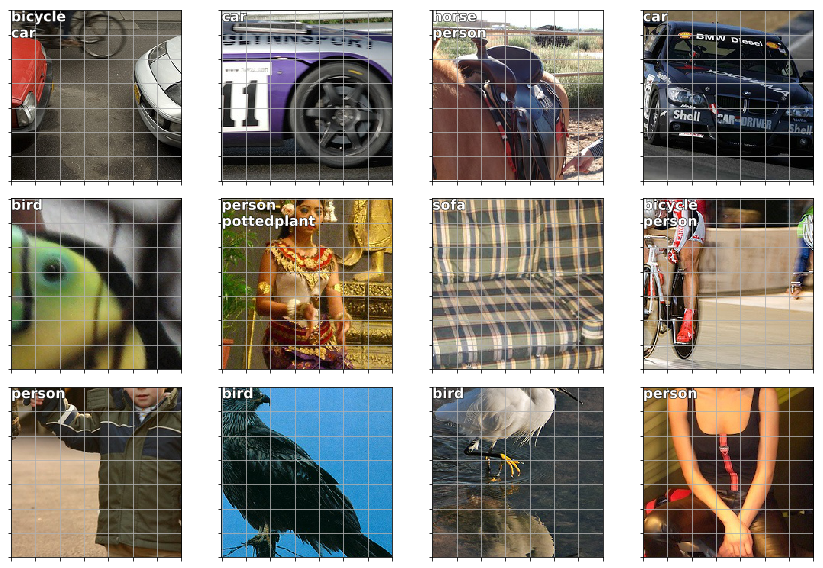

In [30]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ima = to_np(x)[i]
    ima = np.rollaxis(ima,0,3)
    ya = np.nonzero(y[i]>0.4)
    if ya[0].any():
        b = '\n'.join(cats[o+1] for o in ya[0])
    else:
        b = 'unknown'
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

In [9]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
sz=224
bs=64

In [10]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [11]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [12]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

In [13]:
df.head()

fn                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

In [14]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [15]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [16]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [17]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [30]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [31]:
trn_mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([16]),
       array([17,  8, 14, 14, 14]), array([6])], dtype=object)

In [32]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


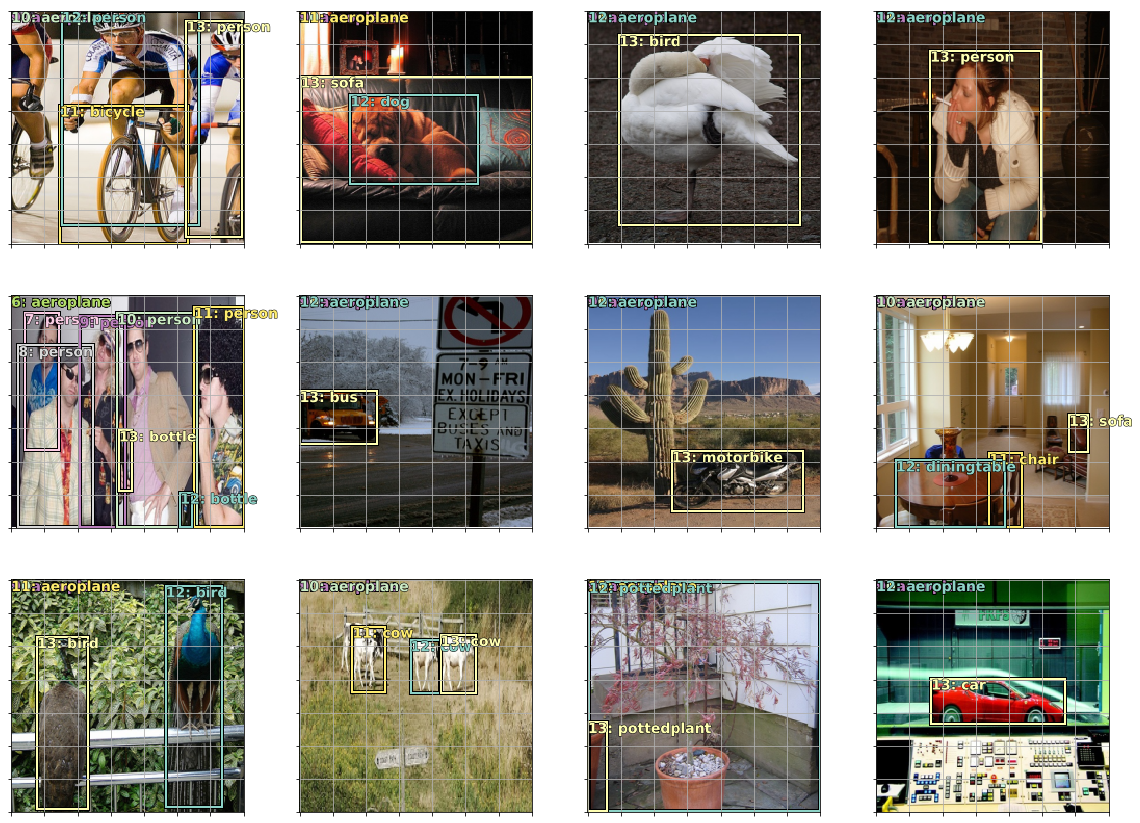

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [34]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [35]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

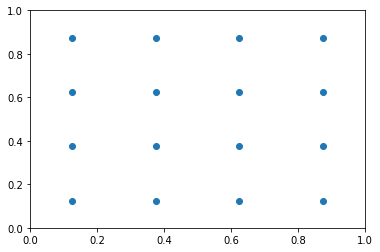

In [36]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [37]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [38]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]], device='cuda:0')

In [39]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

In [40]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [41]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [42]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

In [43]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [44]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [45]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [46]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)


In [47]:
batch = learn.model(x)

In [64]:
ssd_loss(batch, y, True)

tensor([0.1947, 0.1168, 0.2652], device='cuda:0')
tensor([20, 20, 14, 20, 20, 20, 20, 20, 20, 20,  1, 14, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.2885, 0.0888], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 17, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.0990], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20,  2, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.1608], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 14, 20, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.3237, 0.2153, 0.2558, 0.2013, 0.2526, 0.0485, 0.0879],
       device='cuda:0')
tensor([20, 20, 20, 20, 14, 20, 20, 20, 14,  4, 14, 14, 20, 20, 20,  4],
       device='cuda:0')
tensor([0.3258], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 20, 20,  5, 20, 20, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.2704], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13, 20],
       device='cuda:0')
tens

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

tensor([0.2471], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.3207, 0.2089, 0.6309, 0.1183, 0.2568], device='cuda:0')
tensor([20, 20, 20, 20, 20, 14, 20, 20, 14, 14, 14, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.0839], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20,  7, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.1024, 0.2968], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 14, 20, 20, 20, 12, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.0838], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.2832, 0.1478, 0.0903, 0.3304, 0.1316, 0.1940], device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 20, 20,  9,  9,  9,  9, 20, 20, 20, 20],
       device='cuda:0')
tensor([0.4223, 0.1600, 0.2250, 0.3211], device='cuda:0')
tensor([20, 20, 20, 20, 20, 14, 20, 20, 14, 20, 14, 14, 20, 20, 20, 20],
   

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

In [53]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

  0%|          | 0/32 [00:00<?, ?it/s]                    torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  3%|▎         | 1/32 [00:05<02:36,  5.06s/it, loss=109]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  6%|▋         | 2/32 [00:06<01:57,  3.93s/it, loss=119]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  9%|▉         | 3/32 [00:07<01:30,  3.11s/it, loss=123]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p


torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
 12%|█▎        | 4/32 [00:08<01:10,  2.52s/it, loss=120]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 16%|█▌        | 5/32 [00:09<00:57,  2.13s/it, loss=118]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 19%|█▉        | 6/32 [00:11<00:48,  1.88s/it, loss=118]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 22%|██▏       | 7/32 [00:12<00:43,  1.72s/it, loss=117]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 25%|██▌       | 8/32 [00:13<00:37,  1.58s/it, loss=116]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 28%|██▊       | 9/32 [00:14<00:32,  1.41s/it, loss=119]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p


torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 31%|███▏      | 10/32 [00:15<00:29,  1.33s/it, loss=119]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 34%|███▍      | 11/32 [00:17<00:26,  1.26s/it, loss=121]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p


torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 38%|███▊      | 12/32 [00:18<00:25,  1.25s/it, loss=122]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 41%|████      | 13/32 [00:19<00:24,  1.27s/it, loss=120]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 44%|████▍     | 14/32 [00:20<00:22,  1.24s/it, loss=118]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 47%|████▋     | 15/32 [00:22<00:21,  1.25s/it, loss=117]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p


torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 50%|█████     | 16/32 [00:23<00:20,  1.27s/it, loss=115]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 53%|█████▎    | 17/32 [00:24<00:18,  1.22s/it, loss=115]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p


torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 56%|█████▋    | 18/32 [00:25<00:16,  1.18s/it, loss=112]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 59%|█████▉    | 19/32 [00:26<00:15,  1.18s/it, loss=110]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 62%|██████▎   | 20/32 [00:27<00:13,  1.16s/it, loss=107]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 66%|██████▌   | 21/32 [00:28<00:12,  1.14s/it, loss=105]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 69%|██████▉   | 22/32 [00:30<00:11,  1.19s/it, loss=104]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 72%|███████▏  | 23/32 [00:31<00:10,  1.18s/it, loss=103]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 75%|███████▌  | 24/32 [00:32<00:09,  1.14s/it, loss=102]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
 78%|███████▊  | 25/32 [00:33<00:07,  1.08s/it, loss=100]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 81%|████████▏ | 26/32 [00:34<00:06,  1.06s/it, loss=99.4]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
 84%|████████▍ | 27/32 [00:35<00:04,  1.00it/s, loss=98.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([1

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 88%|████████▊ | 28/32 [00:35<00:03,  1.17it/s, loss=97.4]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 91%|█████████ | 29/32 [00:36<00:02,  1.31it/s, loss=97.9]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 94%|█████████▍| 30/32 [00:36<00:01,  1.44it/s, loss=102] torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 97%|█████████▋| 31/32 [00:37<00:00,  1.54it/s, loss=110]torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([1

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])


/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([1

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([1

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([1

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([1

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([1

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([16, 21])
torch.Size([1

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

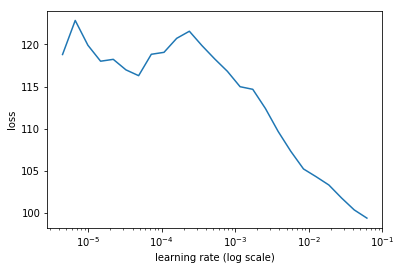

In [62]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [54]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

  0%|          | 0/32 [00:00<?, ?it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  3%|▎         | 1/32 [00:06<03:35,  6.94s/it, loss=82.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  6%|▋         | 2/32 [00:08<02:35,  5.19s/it, loss=82.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  9%|▉         | 3/32 [00:09<01:55,  3.98s/it, loss=81.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 12%|█▎        | 4/32 [00:10<01:26,  3.08s/it, loss=79.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 16%|█▌        | 5/32 [00:11<01:12,  2.70s/it, loss=78.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 19%|█▉        | 6/32 [00:13<00:58,  2.23s/it, loss=77.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 22%|██▏       | 7/32 [00:14<00:47,  1.89s/it, loss=75.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 25%|██▌       | 8/32 [00:15<00:39,  1.64s/it, loss=73]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 28%|██▊       | 9/32 [00:16<00:33,  1.47s/it, loss=71]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 31%|███▏      | 10/32 [00:17<00:30,  1.37s/it, loss=68.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 34%|███▍      | 11/32 [00:18<00:27,  1.30s/it, loss=67]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 38%|███▊      | 12/32 [00:19<00:25,  1.27s/it, loss=65.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 41%|████      | 13/32 [00:20<00:23,  1.22s/it, loss=63.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 44%|████▍     | 14/32 [00:22<00:21,  1.18s/it, loss=61.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 47%|████▋     | 15/32 [00:23<00:20,  1.21s/it, loss=60.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 50%|█████     | 16/32 [00:24<00:18,  1.18s/it, loss=58.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 53%|█████▎    | 17/32 [00:25<00:18,  1.25s/it, loss=57]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 56%|█████▋    | 18/32 [00:27<00:17,  1.25s/it, loss=55.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 59%|█████▉    | 19/32 [00:28<00:15,  1.22s/it, loss=54.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 62%|██████▎   | 20/32 [00:29<00:15,  1.29s/it, loss=53.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 66%|██████▌   | 21/32 [00:31<00:15,  1.38s/it, loss=52]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 69%|██████▉   | 22/32 [00:32<00:13,  1.34s/it, loss=51.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 72%|███████▏  | 23/32 [00:33<00:11,  1.31s/it, loss=50.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 75%|███████▌  | 24/32 [00:34<00:10,  1.27s/it, loss=49.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 78%|███████▊  | 25/32 [00:36<00:09,  1.33s/it, loss=48.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 81%|████████▏ | 26/32 [00:37<00:07,  1.29s/it, loss=48]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 84%|████████▍ | 27/32 [00:38<00:06,  1.27s/it, loss=47.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 88%|████████▊ | 28/32 [00:39<00:04,  1.20s/it, loss=46.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 91%|█████████ | 29/32 [00:40<00:03,  1.18s/it, loss=45.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 94%|█████████▍| 30/32 [00:41<00:01,  1.01it/s, loss=45.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

epoch      trn_loss   val_loss   
    0      43.351882  31.061495 
  0%|          | 0/32 [00:00<?, ?it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  3%|▎         | 1/32 [00:05<02:37,  5.09s/it, loss=42.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  6%|▋         | 2/32 [00:06<01:57,  3.91s/it, loss=42.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  9%|▉         | 3/32 [00:07<01:29,  3.09s/it, loss=41.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 12%|█▎        | 4/32 [00:08<01:12,  2.58s/it, loss=41.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 16%|█▌        | 5/32 [00:09<00:57,  2.15s/it, loss=41.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 19%|█▉        | 6/32 [00:11<00:48,  1.85s/it, loss=40.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 22%|██▏       | 7/32 [00:12<00:40,  1.63s/it, loss=40.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 25%|██▌       | 8/32 [00:13<00:35,  1.49s/it, loss=40.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 28%|██▊       | 9/32 [00:14<00:31,  1.38s/it, loss=39.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 31%|███▏      | 10/32 [00:15<00:29,  1.36s/it, loss=39.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 34%|███▍      | 11/32 [00:17<00:28,  1.34s/it, loss=38.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 38%|███▊      | 12/32 [00:18<00:26,  1.31s/it, loss=38.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 41%|████      | 13/32 [00:19<00:23,  1.26s/it, loss=38.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 44%|████▍     | 14/32 [00:20<00:22,  1.25s/it, loss=37.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 47%|████▋     | 15/32 [00:21<00:20,  1.21s/it, loss=37.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 50%|█████     | 16/32 [00:23<00:19,  1.20s/it, loss=37.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 53%|█████▎    | 17/32 [00:24<00:17,  1.19s/it, loss=37]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 56%|█████▋    | 18/32 [00:25<00:16,  1.16s/it, loss=36.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 59%|█████▉    | 19/32 [00:26<00:15,  1.16s/it, loss=36.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 62%|██████▎   | 20/32 [00:27<00:13,  1.16s/it, loss=36.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 66%|██████▌   | 21/32 [00:28<00:12,  1.15s/it, loss=36]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 69%|██████▉   | 22/32 [00:29<00:11,  1.14s/it, loss=35.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 72%|███████▏  | 23/32 [00:30<00:10,  1.11s/it, loss=35.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 75%|███████▌  | 24/32 [00:31<00:08,  1.06s/it, loss=35.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 78%|███████▊  | 25/32 [00:32<00:06,  1.09it/s, loss=35.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 81%|████████▏ | 26/32 [00:32<00:04,  1.23it/s, loss=35.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 84%|████████▍ | 27/32 [00:33<00:03,  1.37it/s, loss=34.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 88%|████████▊ | 28/32 [00:34<00:02,  1.47it/s, loss=34.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 91%|█████████ | 29/32 [00:34<00:01,  1.55it/s, loss=34.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 94%|█████████▍| 30/32 [00:35<00:01,  1.62it/s, loss=34.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

    1      33.677551  28.502459 
  0%|          | 0/32 [00:00<?, ?it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  3%|▎         | 1/32 [00:04<02:30,  4.85s/it, loss=33.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  6%|▋         | 2/32 [00:06<01:52,  3.76s/it, loss=33.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  9%|▉         | 3/32 [00:07<01:26,  2.99s/it, loss=33.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 12%|█▎        | 4/32 [00:08<01:09,  2.49s/it, loss=32.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 16%|█▌        | 5/32 [00:09<00:57,  2.14s/it, loss=32.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 19%|█▉        | 6/32 [00:10<00:47,  1.82s/it, loss=32.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 22%|██▏       | 7/32 [00:12<00:40,  1.62s/it, loss=32.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 25%|██▌       | 8/32 [00:13<00:35,  1.48s/it, loss=32.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 28%|██▊       | 9/32 [00:14<00:33,  1.44s/it, loss=32.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 31%|███▏      | 10/32 [00:15<00:30,  1.38s/it, loss=31.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 34%|███▍      | 11/32 [00:16<00:27,  1.30s/it, loss=31.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 38%|███▊      | 12/32 [00:18<00:25,  1.27s/it, loss=31.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 41%|████      | 13/32 [00:19<00:23,  1.23s/it, loss=31.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 44%|████▍     | 14/32 [00:20<00:21,  1.18s/it, loss=31.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 47%|████▋     | 15/32 [00:21<00:19,  1.17s/it, loss=31.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 50%|█████     | 16/32 [00:22<00:18,  1.16s/it, loss=31.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 53%|█████▎    | 17/32 [00:23<00:17,  1.14s/it, loss=31]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 56%|█████▋    | 18/32 [00:24<00:15,  1.12s/it, loss=30.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 59%|█████▉    | 19/32 [00:25<00:14,  1.09s/it, loss=30.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 62%|██████▎   | 20/32 [00:26<00:13,  1.10s/it, loss=30.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 66%|██████▌   | 21/32 [00:28<00:12,  1.16s/it, loss=30.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 69%|██████▉   | 22/32 [00:29<00:11,  1.18s/it, loss=30.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 72%|███████▏  | 23/32 [00:30<00:10,  1.20s/it, loss=30.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 75%|███████▌  | 24/32 [00:31<00:09,  1.15s/it, loss=30.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 78%|███████▊  | 25/32 [00:32<00:07,  1.07s/it, loss=30.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 81%|████████▏ | 26/32 [00:33<00:05,  1.09it/s, loss=30.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 84%|████████▍ | 27/32 [00:33<00:04,  1.24it/s, loss=30.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 88%|████████▊ | 28/32 [00:34<00:02,  1.37it/s, loss=30.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 91%|█████████ | 29/32 [00:34<00:02,  1.48it/s, loss=30.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 94%|█████████▍| 30/32 [00:35<00:01,  1.56it/s, loss=30.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

    2      29.48552   27.361279 
  0%|          | 0/32 [00:00<?, ?it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  3%|▎         | 1/32 [00:05<02:42,  5.25s/it, loss=29.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  6%|▋         | 2/32 [00:06<02:00,  4.03s/it, loss=29.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  9%|▉         | 3/32 [00:07<01:32,  3.18s/it, loss=29.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 12%|█▎        | 4/32 [00:08<01:13,  2.62s/it, loss=29.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 16%|█▌        | 5/32 [00:10<00:58,  2.18s/it, loss=29]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 19%|█▉        | 6/32 [00:11<00:48,  1.88s/it, loss=28.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 22%|██▏       | 7/32 [00:12<00:41,  1.66s/it, loss=28.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 25%|██▌       | 8/32 [00:13<00:36,  1.50s/it, loss=28.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 28%|██▊       | 9/32 [00:14<00:31,  1.39s/it, loss=28.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 31%|███▏      | 10/32 [00:15<00:27,  1.27s/it, loss=28.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 34%|███▍      | 11/32 [00:16<00:26,  1.25s/it, loss=28.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 38%|███▊      | 12/32 [00:18<00:24,  1.25s/it, loss=28.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 41%|████      | 13/32 [00:19<00:23,  1.22s/it, loss=28.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 44%|████▍     | 14/32 [00:20<00:22,  1.25s/it, loss=28.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 47%|████▋     | 15/32 [00:21<00:20,  1.22s/it, loss=28.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 50%|█████     | 16/32 [00:22<00:19,  1.21s/it, loss=28.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 53%|█████▎    | 17/32 [00:24<00:18,  1.23s/it, loss=28]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 56%|█████▋    | 18/32 [00:25<00:17,  1.25s/it, loss=27.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 59%|█████▉    | 19/32 [00:26<00:16,  1.25s/it, loss=27.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 62%|██████▎   | 20/32 [00:27<00:14,  1.21s/it, loss=27.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 21/32 [00:28<00:12,  1.17s/it, loss=27.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 69%|██████▉   | 22/32 [00:30<00:11,  1.15s/it, loss=27.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 72%|███████▏  | 23/32 [00:31<00:10,  1.15s/it, loss=27.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 75%|███████▌  | 24/32 [00:32<00:09,  1.13s/it, loss=27.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 78%|███████▊  | 25/32 [00:32<00:07,  1.01s/it, loss=27.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 81%|████████▏ | 26/32 [00:33<00:05,  1.15it/s, loss=27.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 84%|████████▍ | 27/32 [00:34<00:03,  1.30it/s, loss=27.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 88%|████████▊ | 28/32 [00:34<00:02,  1.42it/s, loss=27.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 91%|█████████ | 29/32 [00:35<00:01,  1.52it/s, loss=27.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 94%|█████████▍| 30/32 [00:35<00:01,  1.61it/s, loss=27.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

    3      26.528729  26.45489  
  0%|          | 0/32 [00:00<?, ?it/s]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  3%|▎         | 1/32 [00:04<02:33,  4.94s/it, loss=26.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  6%|▋         | 2/32 [00:06<01:54,  3.82s/it, loss=26.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

  9%|▉         | 3/32 [00:07<01:28,  3.06s/it, loss=26.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 12%|█▎        | 4/32 [00:08<01:09,  2.49s/it, loss=26.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 16%|█▌        | 5/32 [00:09<00:57,  2.13s/it, loss=26.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 19%|█▉        | 6/32 [00:10<00:47,  1.82s/it, loss=26.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 22%|██▏       | 7/32 [00:12<00:41,  1.67s/it, loss=26]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 25%|██▌       | 8/32 [00:13<00:36,  1.53s/it, loss=26]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 28%|██▊       | 9/32 [00:14<00:32,  1.40s/it, loss=25.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 31%|███▏      | 10/32 [00:15<00:30,  1.38s/it, loss=25.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 34%|███▍      | 11/32 [00:17<00:27,  1.30s/it, loss=25.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 38%|███▊      | 12/32 [00:18<00:24,  1.25s/it, loss=25.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 41%|████      | 13/32 [00:19<00:23,  1.25s/it, loss=25.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 44%|████▍     | 14/32 [00:20<00:22,  1.27s/it, loss=25.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 47%|████▋     | 15/32 [00:21<00:20,  1.20s/it, loss=25.6]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 50%|█████     | 16/32 [00:23<00:19,  1.22s/it, loss=25.5]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 53%|█████▎    | 17/32 [00:24<00:18,  1.24s/it, loss=25.4]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 56%|█████▋    | 18/32 [00:25<00:17,  1.24s/it, loss=25.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 59%|█████▉    | 19/32 [00:26<00:15,  1.19s/it, loss=25.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 62%|██████▎   | 20/32 [00:27<00:14,  1.22s/it, loss=25.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 66%|██████▌   | 21/32 [00:29<00:13,  1.23s/it, loss=25.3]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 69%|██████▉   | 22/32 [00:30<00:11,  1.19s/it, loss=25.2]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 72%|███████▏  | 23/32 [00:31<00:10,  1.18s/it, loss=25.1]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 75%|███████▌  | 24/32 [00:32<00:08,  1.06s/it, loss=25]  

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 78%|███████▊  | 25/32 [00:32<00:06,  1.08it/s, loss=25]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 81%|████████▏ | 26/32 [00:33<00:04,  1.23it/s, loss=25]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 84%|████████▍ | 27/32 [00:33<00:03,  1.36it/s, loss=24.9]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 88%|████████▊ | 28/32 [00:34<00:02,  1.47it/s, loss=24.8]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 91%|█████████ | 29/32 [00:35<00:01,  1.56it/s, loss=24.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

 94%|█████████▍| 30/32 [00:35<00:01,  1.63it/s, loss=24.7]

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

    4      24.349421  25.871273 



/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/workmailofyi/anaconda3/envs/fastai0.7/lib/python3.6/site-p

[25.871273315429686]

In [55]:
learn.save('0')

In [56]:
learn.load('0')

In [57]:
x, y = next(iter(md.val_dl))
x, y = V(x), V(y)
learn.model.eval()
batch = learn.model(x)
b_clas, b_bb = batch

In [58]:
b_clas.size(), b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [59]:
idx = 7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima = md.val_ds.ds.denorm(to_np(x))[idx]
bbox, clas = get_y(y[0][idx], y[1][idx])
bbox, clas

(tensor([[0.6786, 0.4866, 0.9911, 0.6250],
         [0.7098, 0.0848, 0.9911, 0.5491],
         [0.5134, 0.8304, 0.6696, 0.9063]], device='cuda:0'),
 tensor([ 8, 10, 17], device='cuda:0'))

In [60]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

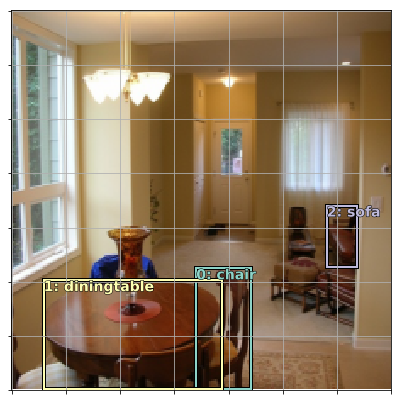

In [61]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

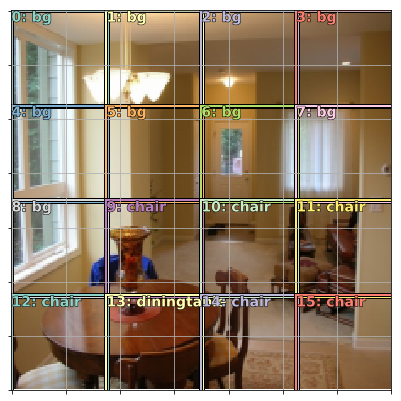

In [62]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [63]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [64]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [65]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(V(x))

In [66]:
batch[0].size(),batch[1].size()

(torch.Size([64, 21, 21]), torch.Size([64, 21, 4]))

In [67]:
ssd_loss(batch, y, True)

RuntimeError: The size of tensor a (21) must match the size of tensor b (16) at non-singleton dimension 0

In [ ]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)